In [1]:
!pip install git+https://github.com/rtqichen/torchdiffeq

  Cloning https://github.com/rtqichen/torchdiffeq to /tmp/pip-req-build-i8gwgxwu
  Running command git clone -q https://github.com/rtqichen/torchdiffeq /tmp/pip-req-build-i8gwgxwu
  Created wheel for torchdiffeq: filename=torchdiffeq-0.2.1-cp37-none-any.whl size=31195 sha256=c97a31de690af3b5e3136092ea7814a5159713cefb61cbed088c47de1330068d
  Stored in directory: /tmp/pip-ephem-wheel-cache-fgolloro/wheels/3f/76/69/01867bf3355c3bc8bae7e556b17b44c395b6cda5e76fd8ddc7
Successfully built torchdiffeq


Please upload:


*   ode_const_20_multiclass_reg_x_train.npy
*   ode_const_20_multiclass_reg_x_val.npy
*   ode_const_20_multiclass_reg_y_train.npy
*   ode_const_20_multiclass_reg_y_val.npy



In [2]:
LOCAL_FILES = True

if LOCAL_FILES:
  from google.colab import files
  uploaded = files.upload()
else:
  from google.colab import drive
  drive.mount("/content/drive/")

Saving ode_const_20_multiclass_reg_x_train.npy to ode_const_20_multiclass_reg_x_train.npy
Saving ode_const_20_multiclass_reg_x_val.npy to ode_const_20_multiclass_reg_x_val.npy
Saving ode_const_20_multiclass_reg_y_train.npy to ode_const_20_multiclass_reg_y_train.npy
Saving ode_const_20_multiclass_reg_y_val.npy to ode_const_20_multiclass_reg_y_val.npy
Saving ORDER_40e_multiclass_ode.pth to ORDER_40e_multiclass_ode.pth


# Import Libraries

comments:
1. Add relu, dropout, subsamling?, conv?, bidirectional
2. Compare to standard nets
3. For i in range(samples_per_epoch)
4. Add recurent layer after ode

In [3]:
import numpy as np
import random

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader, random_split, TensorDataset

import torch.optim as optim
import torch.nn as nn

from torchdiffeq import odeint_adjoint as odeint

import os

# Define Parameters

In [4]:
epochs = 40

samples_per_epoch = 1000
batch_size = 1  ###########################
# learning_rate = 1e-4

learning_rate = 0.01
device = torch.device("cpu")

num_classes = 5
class_names = ["VoIP", "Video", "File_Transfer", "Chat", "Browsing"]

seq_size = 20
input_dim = 1
bidirectional = False
lstm_num_layers = 2 # layer should be changed 

tol = 1e-3
ode_hidden_dim = 32

MODEL_NAME = "ORDER_ode_const_20_multiclass_reg"
PATH_PREFIX = "ode_const_20_multiclass_"

# Import Train and Validation Data

In [5]:
data_train = np.load(PATH_PREFIX + "reg_x_train.npy")
y_train = np.load(PATH_PREFIX + "reg_y_train.npy")
data_val = np.load(PATH_PREFIX + "reg_x_val.npy")
y_val = np.load(PATH_PREFIX + "reg_y_val.npy")


print(data_train.shape, y_train.shape)
print(data_val.shape, y_val.shape)

(12922, 2, 20) (12922,)
(1291, 2, 20) (1291,)


In [6]:
from sklearn.utils import shuffle
data_train, y_train = shuffle(data_train, y_train)
data_val, y_val = shuffle(data_val, y_val)

print(y_val[:100])

[2. 2. 0. 2. 0. 2. 2. 4. 1. 1. 1. 1. 1. 2. 1. 0. 1. 2. 2. 4. 2. 1. 2. 2.
 3. 1. 0. 1. 2. 2. 2. 1. 3. 4. 1. 0. 0. 4. 0. 2. 4. 1. 3. 1. 2. 1. 0. 4.
 4. 4. 3. 4. 4. 2. 2. 2. 2. 0. 2. 4. 2. 2. 0. 4. 1. 4. 0. 0. 0. 1. 1. 4.
 4. 2. 1. 0. 0. 0. 2. 3. 1. 4. 2. 0. 1. 4. 2. 1. 4. 1. 2. 4. 0. 0. 2. 2.
 0. 2. 0. 4.]


## Generate duration statistics

In [7]:
data_train_durations = data_train[:,1,-1] - data_train[:,1,0]

for i in range(num_classes):
  print(i, str(seq_size) + " packets" , 'regular', class_names[i], 'Avergae duration:', np.mean(data_train_durations[y_train==i]), 
        'Median duration:', np.median(data_train_durations[y_train==i]), 'Std duration:', np.std(data_train_durations[y_train==i]))

0 20 packets regular VoIP Avergae duration: 0.41137532684696543 Median duration: 0.367074999999943 Std duration: 0.1491912556882431
1 20 packets regular Video Avergae duration: 0.0974217524238231 Median duration: 0.07098949999999249 Std duration: 0.37240367702366517
2 20 packets regular File_Transfer Avergae duration: 0.04973022296618646 Median duration: 0.0012929999999755637 Std duration: 0.76972555182821
3 20 packets regular Chat Avergae duration: 36.86679220591341 Median duration: 6.0548670000000016 Std duration: 89.98343226300861
4 20 packets regular Browsing Avergae duration: 20.781798506192956 Median duration: 0.8331905000000002 Std duration: 45.332844835447666


## Generate train and test sets

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


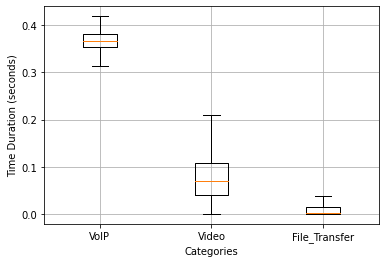

In [9]:
import matplotlib.pyplot as plt

plt.boxplot([data_train_durations[y_train==i] for i in range(3)], labels=class_names[:3], showfliers=False)
plt.xlabel("Categories")
plt.ylabel("Time Duration (seconds)")
plt.grid()
plt.show()

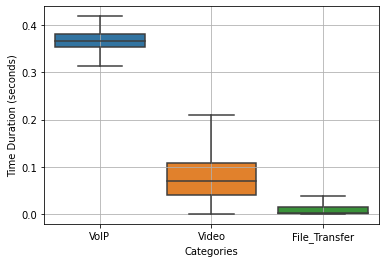

In [10]:
import seaborn as sns
ax = sns.boxplot(data=[data_train_durations[y_train==i] for i in range(3)], showfliers=False)
plt.xticks(np.arange(3), class_names[:3])
plt.xlabel("Categories")
plt.ylabel("Time Duration (seconds)")
plt.grid()
plt.show()

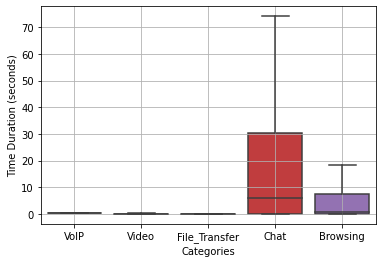

In [11]:
ax = sns.boxplot(data=[data_train_durations[y_train==i] for i in range(5)], showfliers=False)
plt.xticks(np.arange(5), class_names[:5])
plt.xlabel("Categories")
plt.ylabel("Time Duration (seconds)")
plt.grid()
plt.show()

In [12]:
x_train = torch.from_numpy(data_train[:,0,:].reshape((data_train.shape[0], data_train.shape[2], 1))).float()  #.float()
t_train = torch.from_numpy(data_train[:,1,:]).float()

x_val = torch.from_numpy(data_val[:,0,:].reshape((data_val.shape[0], data_val.shape[2], 1))).float()
t_val = torch.from_numpy(data_val[:,1,:]).float()

y_train = torch.from_numpy(y_train).long()
y_val = torch.from_numpy(y_val).long()
                         
print(x_train.shape, t_train.shape, y_train.shape)
print(x_val.shape, t_val.shape, y_val.shape)

torch.Size([12922, 20, 1]) torch.Size([12922, 20]) torch.Size([12922])
torch.Size([1291, 20, 1]) torch.Size([1291, 20]) torch.Size([1291])


In [13]:
MTU = 1500
x_train = (x_train - MTU/2)/MTU
x_val = (x_val - MTU/2)/MTU
print(x_val[0:2])

tensor([[[ 0.4373],
         [ 0.4320],
         [ 0.4320],
         [ 0.4320],
         [ 0.4320],
         [ 0.4320],
         [ 0.4320],
         [ 0.4320],
         [ 0.4320],
         [ 0.4320],
         [ 0.4320],
         [ 0.4320],
         [ 0.4320],
         [ 0.4320],
         [ 0.4320],
         [ 0.4320],
         [ 0.4320],
         [ 0.4320],
         [ 0.4320],
         [ 0.4320]],

        [[ 0.5000],
         [ 0.5000],
         [-0.0027],
         [ 0.5000],
         [ 0.5000],
         [ 0.5000],
         [ 0.5000],
         [ 0.5000],
         [ 0.5000],
         [ 0.5000],
         [ 0.5000],
         [ 0.5000],
         [ 0.5000],
         [ 0.5000],
         [ 0.5000],
         [ 0.5000],
         [ 0.5000],
         [ 0.5000],
         [ 0.5000],
         [ 0.5000]]])


In [14]:
m1 = 0
mask1 = []
for i, ts in enumerate(t_train):
    if not np.all(np.diff(ts) > 0):
        m1 += 1
    else:
        mask1.append(i)
        
m2 = 0
mask2 = []
for i, ts in enumerate(t_val):
    if not np.all(np.diff(ts) > 0):
        m2 += 1
    else:
        mask2.append(i)
        
print(m1, m2)

2920 286


In [15]:
x_train, t_train, y_train = x_train[mask1], t_train[mask1], y_train[mask1]
x_val, t_val, y_val = x_val[mask2], t_val[mask2], y_val[mask2]

print(x_train.shape, t_train.shape, y_train.shape)
print(x_val.shape, t_val.shape, y_val.shape)

torch.Size([10002, 20, 1]) torch.Size([10002, 20]) torch.Size([10002])
torch.Size([1005, 20, 1]) torch.Size([1005, 20]) torch.Size([1005])


In [16]:
def check_for_None(x, t, y):
  for i in range(len(x)):
    if True in torch.isnan(x[i]):
      print(i, x[i])
    if True in torch.isnan(t[i]):
      print(i, t[i])
    if len(x[i]) != len(t[i]):
      print(i, x[i], t[i])
    if True in torch.isnan(y[i]):
      print(i, y[i])

check_for_None(x_train, t_train, y_train)
check_for_None(x_val, t_val, y_val)

In [17]:
train_set = TensorDataset(x_train, t_train, y_train)
test_set = TensorDataset(x_val, t_val, y_val)

## Define Loaders

In [18]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=1,drop_last=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=1,drop_last=True)

# Define Model

In [19]:
class ODEFunc(nn.Module):

    def __init__(self, input_dim, hidden_dim):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, input_dim),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, x):
        return self.net(x)

In [20]:
class LSTMClassifier(nn.Module):

    def __init__(self, input_dim, seq_size, hidden_dim, label_size, batch_size, bidirectional, num_layers, ode_func):
        super(LSTMClassifier, self).__init__()
        self.input_dim = input_dim
        self.seq_size = seq_size
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, bidirectional=bidirectional, batch_first=True)
        self.hidden = self.init_hidden()

        self.ode_func = ode_func

        dim_1=128 ##
        self.fc = nn.Linear(hidden_dim*seq_size, dim_1) #change it to 256 or 512
        if bidirectional:
            self.fc = nn.Linear(2*hidden_dim*seq_size, dim_1)
        dim_2=64  ##  
        self.fc2 = nn.Linear(dim_1, dim_2) 
        self.hidden2label = nn.Linear(dim_2, label_size)
        
        #self.ode_func = ode_func
        
        #self.fc = nn.Linear(hidden_dim*seq_size, 128)
        #if bidirectional:
        #    self.fc = nn.Linear(2*hidden_dim*seq_size, 128)
        #self.hidden2label = nn.Linear(128, label_size)
        

    def init_hidden(self):
        first_size = 1
        if self.bidirectional:
            first_size = 2
        h0 = Variable(torch.zeros(first_size*self.num_layers, self.batch_size, self.hidden_dim)).float()
        c0 = Variable(torch.zeros(first_size*self.num_layers, self.batch_size, self.hidden_dim)).float()
        return (h0, c0)

    def forward(self, x, t):
        lstm_out, self.hidden = self.lstm(x, self.hidden)
#         print(lstm_out.shape)
#         print(lstm_out.shape[1], lstm_out.shape[2], self.seq_size, self.hidden_dim)
#         print(lstm_out.shape, lstm_out[:,0,:].shape, t.shape)
        out = odeint(self.ode_func, lstm_out[:,0,:], t[0], rtol=tol, atol=tol)
#         print(out.shape)
        out = out.view(lstm_out.shape)
#         print(out.shape)
        out = out.contiguous().view(-1, lstm_out.shape[1]*lstm_out.shape[2])  #contiguous() ###TTS##
#         print(out.shape)
#         print(lstm_out.shape)
#         print(lstm_out.shape)
#         lstm_out = torch.squeeze(lstm_out)
#         print(lstm_out.shape)
        y = self.fc(out)
        y = F.relu(y)
        y = self.fc2(y) #added new layers
        y = F.relu(y)
        y = self.hidden2label(y)
#         print(y.shape)
        return y
    
    ## For Regular LSTM
    #def forward(self, x):
     #   lstm_out, self.hidden = self.lstm(x, self.hidden)
      #  lstm_out = torch.squeeze(lstm_out)
       # y = self.fc(lstm_out)
        #y = self.hidden2label(y)
        #return y

In [21]:
ode_func = ODEFunc(input_dim, ode_hidden_dim)
if bidirectional:
    ode_func = ODEFunc(input_dim*2, ode_hidden_dim)
model = LSTMClassifier(input_dim, seq_size, input_dim, num_classes, batch_size, bidirectional, lstm_num_layers, ode_func).to(device)

# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate * (0.1 ** (epoch // 10))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer

optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss().to(device)

In [22]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(model)
print('Number of parameters: {}'.format(count_parameters(model)))

LSTMClassifier(
  (lstm): LSTM(1, 1, num_layers=2, batch_first=True)
  (ode_func): ODEFunc(
    (net): Sequential(
      (0): Linear(in_features=1, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (fc): Linear(in_features=20, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (hidden2label): Linear(in_features=64, out_features=5, bias=True)
)
Number of parameters: 11398


# Run model

## Define train and test functions

In [23]:
def train(model, device, train_loader, optimizer, loss_function, epoch):
    model.train()
    correct = 0
    for batch_idx, traindata in enumerate(train_loader):
        x, t, target = traindata
        x, t, target = x.to(device), t.to(device), target.to(device)
        optimizer.zero_grad()
        model.hidden = model.init_hidden()
        output = model(x, t)
        output = torch.reshape(output, (batch_size, num_classes)) ######
        # train accuracy
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        ##

#         print(output.shape, target.shape)
        loss = loss_function(output, target)
#         if batch_idx == 0:
#             loss.backward(retain_graph=True)
#         else:
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0: #%10
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(target), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
    print('\nTrain set: Accuracy: {}/{} ({:.2f}%)\n'.format(
            correct, len(train_loader.dataset),100. * correct / len(train_loader.dataset)))
    train_acc=100. * correct / len(train_loader.dataset)
    return train_acc

def test(model, device, test_loader, loss_function):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for x, t, target in test_loader:
            x, t, target = x.to(device), t.to(device), target.to(device)
            output = model(x, t)
            output = torch.reshape(output, (batch_size, num_classes)) #######
            test_loss += loss_function(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Test Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc=(100. * correct / len(test_loader.dataset))
    return test_loss,test_acc


In [24]:
TRAINED_BEFORE = True

In [25]:
if not TRAINED_BEFORE:
  epoch_array=[]
  accuracy_array=[]
  train_accuracy_array=[]
  best_acc = 0
  #test_loss = 0
  patience,trials =100, 0
  for epoch in range(1, epochs + 1):
      adjust_learning_rate(optimizer, epoch)
    # train(model, device, train_loader, optimizer, loss_function, epoch)
      tr_acc=train(model, device, train_loader, optimizer, loss_function, epoch)
      loss,acc=test(model, device, test_loader, loss_function)
      
      epoch_array.append(epoch)
      accuracy_array.append(acc)
      train_accuracy_array.append(tr_acc)
      print(f'DEBUG pre accuracy {acc}, best accuracy {best_acc}')
      if (acc > best_acc):
          best_acc = acc
          torch.save(model.state_dict(), 'ORDER_40e_multiclass_ode.pth')
          print(f'Epoch {epoch} best model saved with accuracy: {best_acc}')
      else:
          trials += 1
          if trials >= patience:
              print(f'Early stopping on epoch {epoch}')
              break
      print(f'DEBUG post accuracy {acc}, best accuracy {best_acc}')

In [26]:
if not TRAINED_BEFORE:
  print('The training is finished! Restoring the best model weights')

In [ ]:
### Please upload model
if TRAINED_BEFORE:
  if LOCAL_FILES:
    from google.colab import files
    uploaded = files.upload()
  else:
    from google.colab import drive
    drive.mount("/content/drive/")

Saving ORDER_40e_multiclass_ode.pth to ORDER_40e_multiclass_ode.pth


In [27]:
model.load_state_dict(torch.load('ORDER_40e_multiclass_ode.pth'))
model.eval()

LSTMClassifier(
  (lstm): LSTM(1, 1, num_layers=2, batch_first=True)
  (ode_func): ODEFunc(
    (net): Sequential(
      (0): Linear(in_features=1, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (fc): Linear(in_features=20, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (hidden2label): Linear(in_features=64, out_features=5, bias=True)
)

In [28]:
model.eval()

LSTMClassifier(
  (lstm): LSTM(1, 1, num_layers=2, batch_first=True)
  (ode_func): ODEFunc(
    (net): Sequential(
      (0): Linear(in_features=1, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (fc): Linear(in_features=20, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (hidden2label): Linear(in_features=64, out_features=5, bias=True)
)

### Plot history accuracy

In [29]:
import matplotlib.pyplot as plt

#epoch  = [] # save the iteration counts here for plotting
#Accuracy = [] # save the avg loss here for plotting
# save the current training information
#iters.append(n)
#losses.append(float(loss)/batch_size) # compute *average* loss
# plotting
if not TRAINED_BEFORE:
  plt.figure()
  plt.plot(epoch_array,train_accuracy_array,label = "Train accuracy")
  plt.plot(epoch_array,accuracy_array,label = "Test accuracy")
  plt.title("Training Curve (batch_size=1, lr=0.01)")
  plt.xlabel("epoch")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.savefig("graph_" + MODEL_NAME +  " accuracy history", bbox_inches='tight', pad_inches=1)
  #plt.savefig("drive/My Drive/Multiclass/tor/ode_const_50_multiclass_tor/ORDER_40e_multiclass_ode_accuracy_history.png")
  #files.download("drive/My Drive/Code-20200822T090227Z-001/Code/ode_const_10_voip_vs_all_reg/accuracy history new.png") 
  plt.show()

In [30]:

def eval(model, device, test_loader, loss_function):
    model.eval()
    test_loss = 0
    correct = 0
    preds=[]
    true_labels=[]
    with torch.no_grad():
        for batch_idx,testdata in enumerate(test_loader):
            x,t,target=testdata
        #for x, t, target in test_loader:
            x, t, target = x.to(device), t.to(device), target.to(device)
            output = model(x, t)
            output = torch.reshape(output, (batch_size, num_classes)) ###########
            test_loss += loss_function(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            preds.append(pred)
            true_labels.append(target)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return preds,true_labels

preds,true_labels=eval(model, device, test_loader, loss_function)


Test set: Average loss: 0.6361, Accuracy: 768/1005 (76.42%)



Confusion matrix, without normalization
[[268   0   0   0   9]
 [  0 168   4   2  39]
 [  0  36 110   0  43]
 [  0   0   0   0   0]
 [  9  31  10  54 222]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


Normalized confusion matrix
[[0.97 0.   0.   0.   0.03]
 [0.   0.79 0.02 0.01 0.18]
 [0.   0.19 0.58 0.   0.23]
 [ nan  nan  nan  nan  nan]
 [0.03 0.1  0.03 0.17 0.68]]


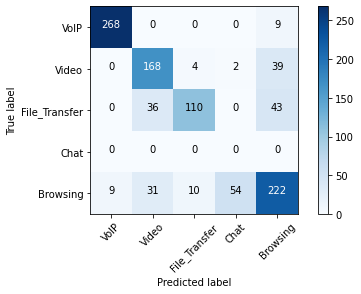

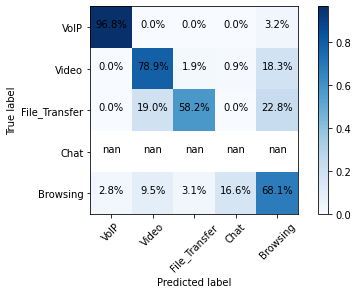

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          fname='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize and cm[i, j] >= 0:
            plt.text(j, i, format(cm[i, j]*100, fmt) + '%',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")    
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(fname, bbox_inches='tight', pad_inches=1)

# Compute confusion matrix
##cnf_matrix = confusion_matrix(y_val_true, y_val_prediction)

#cnf_matrix = confusion_matrix(preds,true_labels)
# cnf_matrix = confusion_matrix(preds, np.argmax(true_labels,axis=-1)) ?????
cnf_matrix = confusion_matrix(preds, true_labels)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization',
                      fname=MODEL_NAME + "_" + 'Confusion_matrix_without_normalization')
#plt.savefig("drive/My Drive/Multiclass/tor/ode_const_50_multiclass_tor/ORDER_40e_multiclass_ode_confusion without.png")
#files.download("drive/My Drive/Code-20200822T090227Z-001/Code/ode_const_10_voip_vs_all_tor/without_ode/confusion without no ode.png")

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix',
                      fname=MODEL_NAME + "_" + 'Normalized_confusion_matrix')
#plt.savefig("drive/My Drive/Multiclass/tor/ode_const_50_multiclass_tor/ORDER_40e_multiclass_ode_confusion with.png")
#files.download("drive/My Drive/Code-20200822T090227Z-001/Code/ode_const_10_voip_vs_all_tor/without_ode/confusion with no ode.png")

plt.show()

In [32]:
from sklearn.metrics import classification_report
print(classification_report(preds,true_labels))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       277
           1       0.71      0.79      0.75       213
           2       0.89      0.58      0.70       189
           3       0.00      0.00      0.00         0
           4       0.71      0.68      0.69       326

    accuracy                           0.76      1005
   macro avg       0.66      0.60      0.62      1005
weighted avg       0.82      0.76      0.78      1005



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Analyze Predictions Confidence

In [33]:
from scipy.special import softmax

def eval_scores(model, device, test_loader, loss_function):
    model.eval()
    test_loss = 0
    correct = 0
    preds=[]
    scores = []
    true_labels=[]
    with torch.no_grad():
        for batch_idx,testdata in enumerate(test_loader):
            x,t,target=testdata
        #for x, t, target in test_loader:
            x, t, target = x.to(device), t.to(device), target.to(device)
            output = model(x, t)
            output = torch.reshape(output, (batch_size, num_classes)) ###########
            test_loss += loss_function(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            preds.append(pred)
            true_labels.append(target)
            correct += pred.eq(target.view_as(pred)).sum().item()
            scores.append(output)

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    scores = softmax(torch.cat(scores).numpy(), axis=1)
    return scores, torch.cat(preds).numpy().squeeze(), torch.cat(true_labels).numpy()

scores, preds, true_labels=eval_scores(model, device, test_loader, loss_function)


Test set: Average loss: 0.6373, Accuracy: 769/1005 (76.52%)



In [34]:
i=0
print("Softmax Scores, pediction score, score of true label, pediction, true_label, correct?")
print(scores[i], max(scores[i]), scores[i][true_labels[i]], preds[i], true_labels[i], preds[i] == true_labels[i])

Softmax Scores, pediction score, score of true label, pediction, true_label, correct?
[0.   0.45 0.09 0.06 0.4 ] 0.44634745 0.44634745 1 1 True


In [35]:
print(np.max(scores, axis=1) > 0.5)

[False  True  True ...  True  True  True]


In [36]:
from sklearn.metrics import accuracy_score

def calc_accuracy_for_confidence_threshold(scores=scores, preds=preds, true_labels=true_labels, confidence_th=0.5):
  indexes = np.max(scores, axis=1) > confidence_th
  remaining = len(preds[indexes])/len(preds)
  accuracy = accuracy_score(true_labels[indexes], preds[indexes])
  print("For condifence threshold of", confidence_th, ":", len(preds[indexes]), "remaining out of", len(preds), "=", remaining, "achieve accuracy of", accuracy)
  return remaining, accuracy


In [37]:
ths = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
remainings = []
accuracies = []
for th in ths:
  remaining, accuracy = calc_accuracy_for_confidence_threshold(confidence_th=th)
  remainings.append(remaining)
  accuracies.append(accuracy)

For condifence threshold of 0.2 : 1005 remaining out of 1005 = 1.0 achieve accuracy of 0.7651741293532338
For condifence threshold of 0.3 : 1005 remaining out of 1005 = 1.0 achieve accuracy of 0.7651741293532338
For condifence threshold of 0.4 : 973 remaining out of 1005 = 0.9681592039800995 achieve accuracy of 0.7738951695786228
For condifence threshold of 0.5 : 835 remaining out of 1005 = 0.8308457711442786 achieve accuracy of 0.8047904191616766
For condifence threshold of 0.6 : 664 remaining out of 1005 = 0.6606965174129353 achieve accuracy of 0.8268072289156626
For condifence threshold of 0.7 : 584 remaining out of 1005 = 0.5810945273631841 achieve accuracy of 0.8493150684931506
For condifence threshold of 0.8 : 526 remaining out of 1005 = 0.5233830845771145 achieve accuracy of 0.8821292775665399
For condifence threshold of 0.9 : 433 remaining out of 1005 = 0.43084577114427863 achieve accuracy of 0.9145496535796767
For condifence threshold of 0.95 : 294 remaining out of 1005 = 0.29

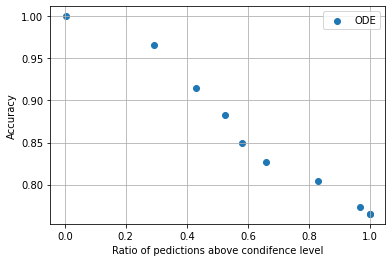

In [38]:
plt.scatter(remainings, accuracies, label="ODE")
plt.xlabel("Ratio of pedictions above condifence level")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

# Plot Confusion Matrix for Specific Threshold

In [41]:
def plot_confusion_matrix_for_confidence_threshold(scores=scores, preds=preds, true_labels=true_labels, confidence_th=0.5):
  indexes = np.max(scores, axis=1) > confidence_th
  remaining = len(preds[indexes])/len(preds)
  accuracy = accuracy_score(true_labels[indexes], preds[indexes])
  print("For condifence threshold of", confidence_th, ":", len(preds[indexes]), "remaining out of", len(preds), "=", remaining, "achieve accuracy of", accuracy)

  cnf_matrix = confusion_matrix(preds[indexes], true_labels[indexes])

  np.set_printoptions(precision=2)

  # Plot non-normalized confusion matrix
  plt.figure()
  plot_confusion_matrix(cnf_matrix, classes=class_names,
                        title='Confusion matrix, without normalization',
                        fname=MODEL_NAME + "_" + 'Confusion_matrix_without_normalization' + "_th_" + str(confidence_th).split('.')[1])
  #plt.savefig("drive/My Drive/Multiclass/tor/ode_const_50_multiclass_tor/ORDER_40e_multiclass_ode_confusion without.png")
  #files.download("drive/My Drive/Code-20200822T090227Z-001/Code/ode_const_10_voip_vs_all_tor/without_ode/confusion without no ode.png")

  # Plot normalized confusion matrix
  plt.figure()
  plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                        title='Normalized confusion matrix',
                        fname=MODEL_NAME + "_" + 'Normalized_confusion_matrix' + "_th_" + str(confidence_th).split('.')[1])
  #plt.savefig("drive/My Drive/Multiclass/tor/ode_const_50_multiclass_tor/ORDER_40e_multiclass_ode_confusion with.png")
  #files.download("drive/My Drive/Code-20200822T090227Z-001/Code/ode_const_10_voip_vs_all_tor/without_ode/confusion with no ode.png")

  plt.show()

For condifence threshold of 0.7 : 584 remaining out of 1005 = 0.5810945273631841 achieve accuracy of 0.8493150684931506
Confusion matrix, without normalization
[[263   0   0   0   4]
 [  0   0   0   0   0]
 [  0  23  86   0  17]
 [  0   0   0   0   0]
 [  4   3   3  34 147]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


Normalized confusion matrix
[[0.99 0.   0.   0.   0.01]
 [ nan  nan  nan  nan  nan]
 [0.   0.18 0.68 0.   0.13]
 [ nan  nan  nan  nan  nan]
 [0.02 0.02 0.02 0.18 0.77]]


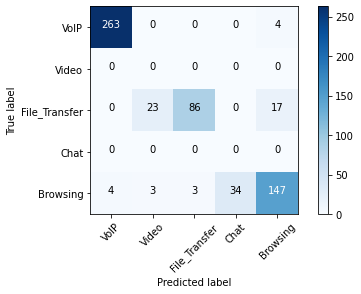

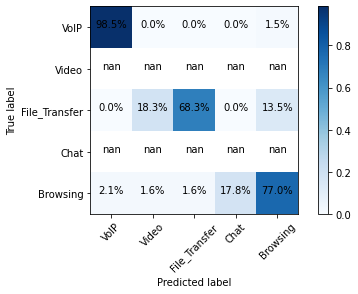

In [44]:
plot_confusion_matrix_for_confidence_threshold(scores, preds, true_labels, confidence_th=0.7)